In [1]:
import os
from glob import glob
import shutil
from zipfile import ZipFile
import json
from tqdm import tqdm
import pandas as pd
src = "/home/kai/workspace/DeepDocs_Project/datalake/source/table_qa"

In [2]:
data = glob(f"{src}/**/*.zip", recursive=True)

In [3]:
# unzip to "./"
for file in data:
    print(f"Unzipping {file}...")
    with ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname(file).replace(src, "./"))
    print(f"Unzipped {file} to {os.path.dirname(file)}")

Unzipping /home/kai/workspace/DeepDocs_Project/datalake/source/table_qa/149.표_정보_질의_응답_데이터/01-1.정식개방데이터/Validation/01.원천데이터/VS.zip...
Unzipped /home/kai/workspace/DeepDocs_Project/datalake/source/table_qa/149.표_정보_질의_응답_데이터/01-1.정식개방데이터/Validation/01.원천데이터/VS.zip to /home/kai/workspace/DeepDocs_Project/datalake/source/table_qa/149.표_정보_질의_응답_데이터/01-1.정식개방데이터/Validation/01.원천데이터
Unzipping /home/kai/workspace/DeepDocs_Project/datalake/source/table_qa/149.표_정보_질의_응답_데이터/01-1.정식개방데이터/Validation/02.라벨링데이터/VL.zip...
Unzipped /home/kai/workspace/DeepDocs_Project/datalake/source/table_qa/149.표_정보_질의_응답_데이터/01-1.정식개방데이터/Validation/02.라벨링데이터/VL.zip to /home/kai/workspace/DeepDocs_Project/datalake/source/table_qa/149.표_정보_질의_응답_데이터/01-1.정식개방데이터/Validation/02.라벨링데이터
Unzipping /home/kai/workspace/DeepDocs_Project/datalake/source/table_qa/149.표_정보_질의_응답_데이터/01-1.정식개방데이터/Training/01.원천데이터/TS.zip...
Unzipped /home/kai/workspace/DeepDocs_Project/datalake/source/table_qa/149.표_정보_질의_응답_데이터/01-1.정식개방데이터/

In [4]:
json_files = glob("149.표_정보_질의_응답_데이터/**/*.json", recursive=True)

In [5]:
from bs4 import BeautifulSoup
def extract_tables_with_thead(html):
    soup = BeautifulSoup(html, "html.parser")
    tables = soup.find_all("table")
    results = []
    for table in tables:
        results.append(str(table))
    return results

In [34]:
records = []
for json_path in json_files:
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    for data_ in tqdm(data['data']):
        for paragraph in data_['paragraphs']:
            context = paragraph['context']
            table_title = paragraph.get('table_title', "")
            tables = extract_tables_with_thead(context)
            # 각 table에 table_title을 caption으로 추가
            if table_title:
                for i, table in enumerate(tables):
                    soup = BeautifulSoup(table, "html.parser")
                    caption = soup.new_tag("caption")
                    caption.string = table_title
                    soup.table.insert(0, caption)
                    tables[i] = str(soup)
            if not tables:
                continue
        for table in tables:
            record = {
                "html": table,
            }
            records.append(record)
df = pd.DataFrame(records)

100%|██████████| 160000/160000 [11:46<00:00, 226.62it/s]


In [37]:
df_unique = df.drop_duplicates(subset=['html'])
print(f"Total unique HTML tables: {len(df_unique)}")
print(f"Total HTML tables: {len(df)}")

Total unique HTML tables: 176631
Total HTML tables: 364766


In [ ]:
import pandas as pd
pd.read_parquet("/home/kai/workspace/DeepDocs_Project/datalake/datalake-prep/train-00010-of-00019-d71d78be9b1f5aa9.parquet")

In [36]:
df_unique.to_parquet("table_qa.parquet", index=False)

In [23]:
import asyncio
from playwright.async_api import async_playwright
async def render_html_and_get_bboxes(html, tags=("table", "tr", "td", "p", "h1", "h2")):
    async with async_playwright() as p:
        if not isinstance(html, str):
            html = str(html)
        browser = await p.chromium.launch()
        page = await browser.new_page(viewport={"width": 1280, "height": 1280})
        await page.set_content(html)
        await page.evaluate("""
            () => {
                // 기본 스타일 강제 적용
                let style = document.createElement('style');
                style.textContent = `
                    table { border-collapse: collapse; }
                    table, th, td { border: 1px solid #333; }
                    th, td { padding: 4px; }
                `;
                document.head.appendChild(style);
            }
        """)
        await page.wait_for_timeout(100)  # 렌더링 안정화
        bboxes = await page.evaluate(
            """
            (tags) => {
                let results = [];
                tags.forEach(tag => {
                    document.querySelectorAll(tag).forEach((el, idx) => {
                        let rect = el.getBoundingClientRect();
                        results.push({
                            tag: tag,
                            idx: idx,
                            text: el.innerText,
                            x: rect.left + window.scrollX,
                            y: rect.top + window.scrollY,
                            width: rect.width,
                            height: rect.height
                        });
                    });
                });
                return results;
            }
            """,
            list(tags)
        )
        img_bytes = await page.screenshot(full_page=True, type='jpeg')
        await browser.close()
        return img_bytes, bboxes

In [24]:
img_bytes, bboxes = await render_html_and_get_bboxes(tables[0])

In [25]:
from PIL import Image, ImageDraw, ImageFont
import io
img = Image.open(io.BytesIO(img_bytes))
draw = ImageDraw.Draw(img)
colors = [f"#{i:02x}{j:02x}00" for i in range(0, 256, 51) for j in range(0, 256, 51)]
for bbox in bboxes:
    tag = bbox['tag']
    text = bbox['text']
    x = bbox['x']
    y = bbox['y']
    width = bbox['width']
    height = bbox['height']
    # random outline color
    color = colors[bbox['idx'] % len(colors)]
    draw.rectangle([x, y, x + width, y + height], outline=color, width=3)

In [27]:
img = Image.open(io.BytesIO(img_bytes))

In [29]:
tables[0]

'<table><tbody><tr><td>판단항목</td><td>세부 판단 항목</td><td>세부 판단 기준 및 방법</td><td>관련서류</td></tr><tr><td rowspan="4">하수급인의 사업수행 능력(100점)</td><td>하수급인의 시공경험(50점)</td><td>➀ 하수급인의 최근 5년간 시공실적 합산액<br/><br/><br/><table><tbody><tr><td>2배이상</td><td>1.5배～2배</td><td>1배～1.5배</td><td>0.5배～1배</td><td>0.5배미만</td></tr><tr><td>50점</td><td>45점</td><td>40점</td><td>35점</td><td>30점</td></tr></tbody></table></td><td rowspan="2">경영상태 평가서 (실적리스트)</td></tr><tr><td>공사업 영위기간(20점)</td><td>② 정보통신 공사업 영위기간<br/><br/><br/><table><tbody><tr><td>10년이상</td><td>5년이상～10년미만</td><td>1년이상～5년미만</td><td>1년미만</td></tr><tr><td>20점</td><td>17점</td><td>14점</td><td>11점</td></tr></tbody></table></td></tr><tr><td>하도급공사의 하자담보 책임 기간(15점)</td><td>③ 공사의 하자담보 책임 기간(「정보통신공사업법 시행령 제37조에 따른 공사의 종류별 하자담보 책임 기간)<br/><br/><br/><table><tbody><tr><td>1년인 공종</td><td>3년인 공종</td><td>5년인 공종</td></tr><tr><td>15점</td><td>13점</td><td>11점</td></tr></tbody></table></td><td>하도급 계약서</td></tr><tr><td>하수급인의 시공여건(15점)</td><td>④ 하수급인이 당해 공사현장 소재 시·도 업체인 경우, 당해 공사현장 소

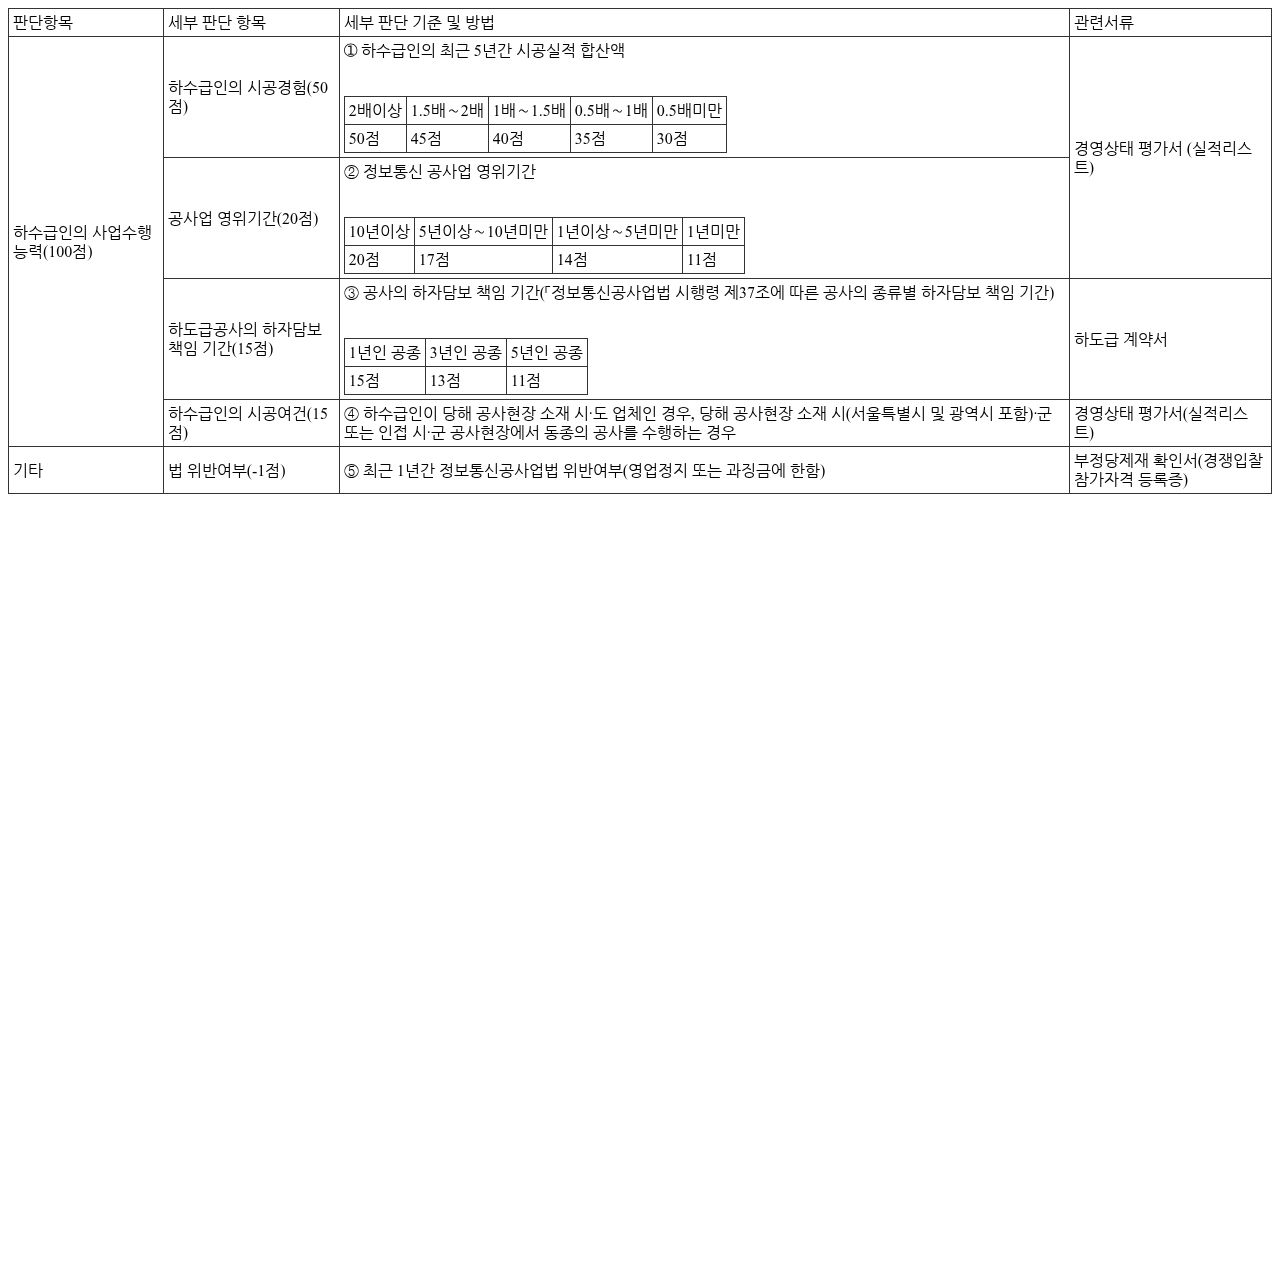

In [28]:
img